In [1]:
import pandas as pd
import numpy as np

In [2]:
import os 

os.chdir('../')

In [3]:
movies = pd.read_csv('data/new_movies.csv')

ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

In [4]:
movie_mapper = np.sort(np.array(movies.movieId.unique()))

def get_movie_hash(id):
    return np.where(movie_mapper == id)[0][0]

def get_movie_id(id):
    return movie_mapper[id]

In [5]:
from sklearn.neighbors import NearestNeighbors
import random

def collaborative_filtering(R, id, k=10):
    # Get k nearest neighbors
    kNN = NearestNeighbors(n_neighbors=20+1, algorithm="brute", metric='cosine')
    kNN.fit(R)
    # Get indices of neighbors (excluding the user themselves)
    distances, indices = kNN.kneighbors(R[id].reshape(1,-1), return_distance=True)
    neighbor_indices = indices[0][1:]
    neighbor_distances = distances[0][1:]
    
    # Convert distances to weights (similarity scores)
    # Using inverse distance weighting
    similarities = 1 / (neighbor_distances + 1e-8)  # add small number to avoid division by zero
    # Normalize weights
    similarities = similarities / np.sum(similarities)
    
    # Get user's current ratings
    user_ratings = R[id]
    unrated_movies = user_ratings == 0
    
    # Calculate predicted ratings
    predicted_ratings = np.zeros_like(user_ratings)
    for idx, neighbor_idx in enumerate(neighbor_indices):
        neighbor_ratings = R[neighbor_idx]
        # Only consider movies the neighbor has rated
        rated_by_neighbor = neighbor_ratings != 0
        # Weight the neighbor's ratings by their similarity
        predicted_ratings += similarities[idx] * neighbor_ratings
    
    # Only keep predictions for movies the user hasn't rated
    predicted_ratings[~unrated_movies] = 0
    
    # Get top 10 movie recommendations
    top_movies_indices = np.argsort(predicted_ratings)[::-1][:k]
    
    # Create recommendations list with (movie_id, predicted_rating)
    recommendations = [idx for idx in top_movies_indices]
    
    return recommendations

In [67]:
def collaborative_filtering(R, id, k=5):
    # Get k nearest neighbors
    kNN = NearestNeighbors(n_neighbors=5, algorithm="brute", metric='cosine')
    kNN.fit(R)
    # Get indices of neighbors (excluding the user themselves)
    distances, indices = kNN.kneighbors(R[id].reshape(1,-1), return_distance=True)
    neighbor_indices = indices[0][1:]
    neighbor_distances = distances[0][1:]
    
    # Convert distances to weights (similarity scores)
    # Using inverse distance weighting
    similarities = 1 / (neighbor_distances + 1e-8)  # add small number to avoid division by zero
    # Normalize weights
    similarities = similarities / np.sum(similarities)
    
    # Get user's current ratings
    user_ratings = R[id]
    unrated_movies = user_ratings == 0
    
    # Calculate predicted ratings
    predicted_ratings = np.zeros_like(user_ratings)
    for idx, neighbor_idx in enumerate(neighbor_indices):
        neighbor_ratings = R[neighbor_idx]
        # Only consider movies the neighbor has rated
        rated_by_neighbor = neighbor_ratings != 0
        # Weight the neighbor's ratings by their similarity
        predicted_ratings += similarities[idx] * neighbor_ratings
    
    # Only keep predictions for movies the user hasn't rated
    predicted_ratings[~unrated_movies] = 0
    
    # Get top 10 movie recommendations
    top_movies_indices = np.argsort(predicted_ratings)[::-1][:k]
    
    # Create recommendations list with (movie_id, predicted_rating)
    recommendations = [idx for idx in top_movies_indices]
    
    return recommendations

In [68]:
class Environment:
    def __init__(self, ratings_df, movies_df):
        self.ratings = ratings_df.copy()  # Create a copy of the ratings DataFrame
        self.movies = movies_df.copy()
        
def create_R(agents, env):
    m = len(env.movies.movieId)
    R = []
    for agent in agents:
        mh = agent.movie_history
        mh_idx = list(map(get_movie_id, mh))
        user_ratings = env.ratings[(env.ratings['userId'] == agent.id) & 
                                 (env.ratings['movieId'].isin(mh_idx))]
        
        # Modified row creation with error handling
        row = []
        for i in range(m):
            if i in mh:
                # Get ratings for this movie
                movie_ratings = user_ratings[user_ratings['movieId'] == get_movie_id(i)].rating
                # Check if we have any ratings
                if len(movie_ratings) > 0:
                    row.append(float(movie_ratings.iloc[0]))
                else:
                    row.append(0)  # No rating found
            else:
                row.append(0)  # Movie not in history
                
        # Convert to numpy array for easier manipulation
        row_array = np.array(row)
        
        # Calculate mean of only non-zero elements
        non_zero_mask = row_array != 0
        if non_zero_mask.any():  # check if there are any non-zero elements
            mean = np.mean(row_array[non_zero_mask])
            # Subtract mean only from non-zero elements
            row_array[non_zero_mask] = row_array[non_zero_mask] - mean
        
        R.append(row_array.tolist())

    return np.array(R)

def check_crime_thriller(hash_id):
    try:
        # Get movie ID
        movie_id = get_movie_id(hash_id)
        if movie_id is None:
            return 0.0
            
        # Get movie genres
        movie_row = movies[movies['movieId'] == movie_id]
        
            
        genres = movie_row['genres'].iloc[0]
        
            
        # Split genres by '|' and check if Crime or Thriller exists
        genre_list = genres.split('|')
        return 5.0 if ('Crime' in genre_list or 'Thriller' in genre_list) else 0.0
        
    except Exception as e:
        print(f"Error processing hash_id {hash_id}: {str(e)}")
        return 0.0



In [69]:
class ReflexAgent:
    def __init__(self, id, env, k=50):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
    
    def get_recs(self, R):
        self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen = random.sample(self.recs, 1)[0]
        self.movie_history.append(self.chosen)

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [get_movie_id(self.chosen)],
            'rating': [random.randint(0, 10)/2],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen
    
class StrictAgent:
    def __init__(self, id, env, k=50):
        self.id = id
        self.env = env  # Store reference to environment
        mh = list(self.env.ratings[self.env.ratings['userId'] == self.id]
                 .sort_values('timestamp').head(k).movieId)
        self.movie_history = list(map(get_movie_hash, mh))
    
    def get_recs(self, R):
        self.recs = collaborative_filtering(R, self.id)
        return self.recs
    
    def action(self):
        self.chosen = random.sample(self.recs, 1)[0]
        self.movie_history.append(self.chosen)

        # Create a new row as a DataFrame
        new_rating = pd.DataFrame({
            'userId': [self.id],
            'movieId': [get_movie_id(self.chosen)],
            'rating': [check_crime_thriller(self.chosen)],
            'timestamp': [82983923]
        })
    
        # Update the ratings DataFrame in the environment
        self.env.ratings = pd.concat([self.env.ratings, new_rating], ignore_index=True)
        return self.chosen

In [96]:
# Create the environment
env = Environment(ratings, movies)

# Initialize agents with environment
users = np.array(pd.Series(ratings.userId.unique()).sample(n=50, random_state=42))
agents = [ReflexAgent(list(users).index(i), env) for i in users[:25]]

strict_agents = [StrictAgent(list(users).index(i), env) for i in users[25:]]

agents = agents+strict_agents



In [77]:
def simulation(timesteps,agents):
    # Run simulation
    recommendations = []
    chosen = []
    
    
    for t in range(timesteps):
        print(f"Creating R matrix for timestep {t}")
        R = create_R(agents, env)
        print(f"R matrix shape: {R.shape}")
        recs = []
        c = []
        for i, agent in enumerate(agents):
            #print(f"Processing agent {i} with {len(agent.movie_history)} movies in history")
            rec = agent.get_recs(R)
            recs.append(rec)
            c.append(agent.action())

        recommendations.append(recs)
        chosen.append(c)
        print(f"Completed timestep: {t}")
    return np.array(recommendations), np.array(chosen)

In [97]:
# Create Hooks at Recs and chosen objects 

recommendations, chosen  = simulation(100,agents)



Creating R matrix for timestep 0
R matrix shape: (50, 9742)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (50, 9742)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (50, 9742)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (50, 9742)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (50, 9742)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (50, 9742)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (50, 9742)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (50, 9742)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (50, 9742)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (50, 9742)
Completed timestep: 9
Creating R matrix for timestep 10
R matrix shape: (50, 9742)
Completed timestep: 10
Creating R matrix for timestep 11
R matrix shape: (50, 9742)
Completed timestep: 11
Creating R m

In [88]:
st_recommendations, st_chosen  = simulation(100, strict_agents)

Creating R matrix for timestep 0
R matrix shape: (50, 9742)
Completed timestep: 0
Creating R matrix for timestep 1
R matrix shape: (50, 9742)
Completed timestep: 1
Creating R matrix for timestep 2
R matrix shape: (50, 9742)
Completed timestep: 2
Creating R matrix for timestep 3
R matrix shape: (50, 9742)
Completed timestep: 3
Creating R matrix for timestep 4
R matrix shape: (50, 9742)
Completed timestep: 4
Creating R matrix for timestep 5
R matrix shape: (50, 9742)
Completed timestep: 5
Creating R matrix for timestep 6
R matrix shape: (50, 9742)
Completed timestep: 6
Creating R matrix for timestep 7
R matrix shape: (50, 9742)
Completed timestep: 7
Creating R matrix for timestep 8
R matrix shape: (50, 9742)
Completed timestep: 8
Creating R matrix for timestep 9
R matrix shape: (50, 9742)
Completed timestep: 9
Creating R matrix for timestep 10
R matrix shape: (50, 9742)
Completed timestep: 10
Creating R matrix for timestep 11
R matrix shape: (50, 9742)
Completed timestep: 11
Creating R m

In [51]:
np.array(st_recommendations).shape

(100, 30, 5)

In [98]:
recommendations = np.array(recommendations)
chosen = np.array(chosen)


In [89]:
recommendations = np.array(st_recommendations)
chosen = np.array(st_chosen)

#np.save('data/strict_recommendations.npy',recommendations)
#np.save('data/strict_chosen.npy',chosen)

In [59]:
# two possible points for counterfactual is watch history , recommendations shown taste 

def extract_genres(recommendations):
    genre_series = movies[movies['movieId'].isin(recommendations)]['genres']
    genre_list = [genre_series.iloc[i].split('|') for i in range(len(genre_series))]
    for genre in ['Drama', 'Comedy']:
        for list in genre_list:
            if genre in list:
                list.remove(genre)
    return genre_list

def jaccard_similarity(x,y): 
    x = set(x)
    y = set(y)
    int = x.intersection(y)
    union = x.union(y)
    return len(int)/(len(union)+1e-10)

def genre_homogeneity(genre_lists):

    similarities = []

    for i in range(len(genre_lists)-1):
        for j in range(1,len(genre_lists)):
            similarities.append(jaccard_similarity(genre_lists[i],genre_lists[j]))

    return np.mean(np.array(similarities)) 

import ast

def convert_string_to_lists(string_lists):
    converted_lists = []
    for string_list in string_lists:
        converted_lists.append(ast.literal_eval(string_list))
    return converted_lists

def extract_actors(recommendations):
    genre_series = movies[movies['movieId'].isin(recommendations)]['actors']
    genre_list = [genre_series.iloc[i] for i in range(len(genre_series))]
    genre_list = convert_string_to_lists(genre_list)
    return genre_list

def extract_directors(recommendations):
    genre_series = movies[movies['movieId'].isin(recommendations)]['director']
    genre_list = [genre_series.iloc[i] for i in range(len(genre_series))]
    return genre_list

def actor_homogeneity(actor_lists):

    similarities = []

    for i in range(len(actor_lists)-1):
        for j in range(1,len(actor_lists)):
            similarities.append(jaccard_similarity(actor_lists[i],actor_lists[j]))

    return np.mean(np.array(similarities)) 

def director_homogeneity(director_ids):

    # Count occurrences of each director
    unique_directors = set(director_ids)
    total_directors = len(director_ids)

    
    # Method 1: Ratio of repeating directors
    repeat_ratio = 1 - (len(unique_directors) / total_directors)
    
    # Method 2: Proportion of most common director
    from collections import Counter
    most_common_count = Counter(director_ids).most_common(1)[0][1]
    dominant_ratio = most_common_count / total_directors
    
    return repeat_ratio

In [99]:
hom_list = []
user_list = [1,14,35,40]
for user in user_list:
    user_100_recommendations = recommendations[:,user,:] 
    hom_scores =[]
    for i in range(100):
        x = user_100_recommendations[i]
        ids = []
        for i in x:
            ids.append(get_movie_id(i))
        hom_scores.append((genre_homogeneity(extract_genres(ids)) + director_homogeneity(extract_directors(ids)) + actor_homogeneity(extract_actors(ids)))/3)
    hom_list.append(hom_scores)


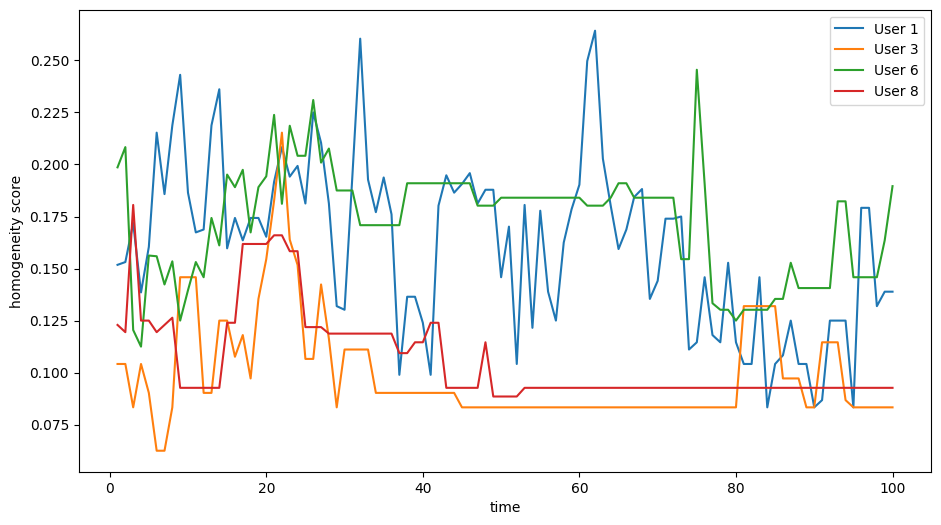

In [85]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 6)) 
plt.xlabel('time')
plt.ylabel('homogeneity score')
plt.plot(range(1,101),hom_list[0], label = f'User {user_list[0]}')
plt.plot(range(1,101),hom_list[1], label = f'User {user_list[1]}')
plt.plot(range(1,101),hom_list[2], label = f'User {user_list[2]}')
plt.plot(range(1,101),hom_list[3], label = f'User {user_list[3]}')

plt.legend(loc='upper right')

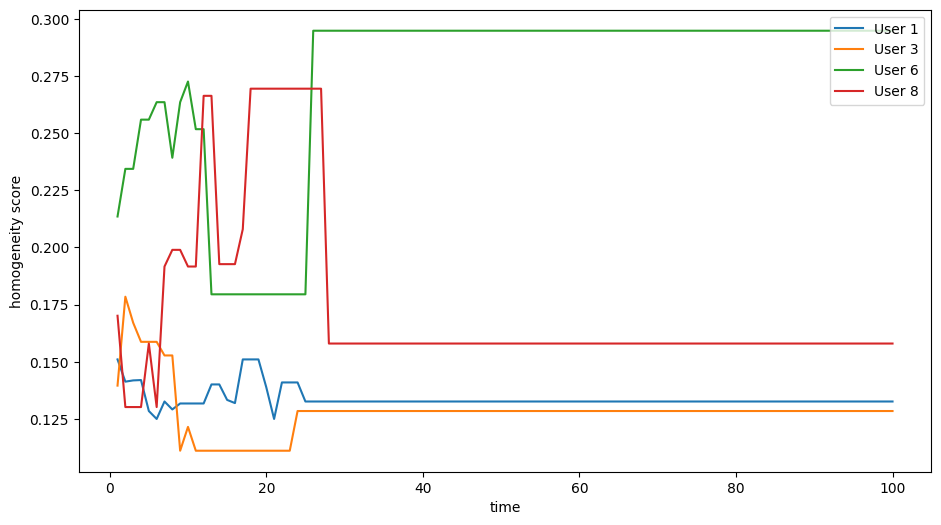

In [81]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 6)) 
plt.xlabel('time')
plt.ylabel('homogeneity score')
plt.plot(range(1,101),hom_list[0], label = f'User {user_list[0]}')
plt.plot(range(1,101),hom_list[1], label = f'User {user_list[1]}')
plt.plot(range(1,101),hom_list[2], label = f'User {user_list[2]}')
plt.plot(range(1,101),hom_list[3], label = f'User {user_list[3]}')

plt.legend(loc='upper right')

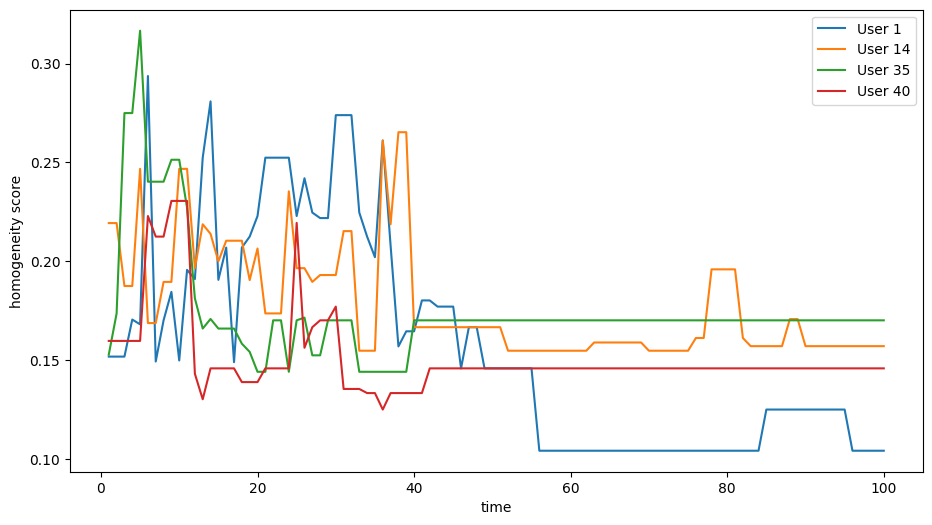

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 6)) 
plt.xlabel('time')
plt.ylabel('homogeneity score')
plt.plot(range(1,101),hom_list[0], label = f'User {user_list[0]}')
plt.plot(range(1,101),hom_list[1], label = f'User {user_list[1]}')
plt.plot(range(1,101),hom_list[2], label = f'User {user_list[2]}')
plt.plot(range(1,101),hom_list[3], label = f'User {user_list[3]}')

plt.legend(loc='upper right')

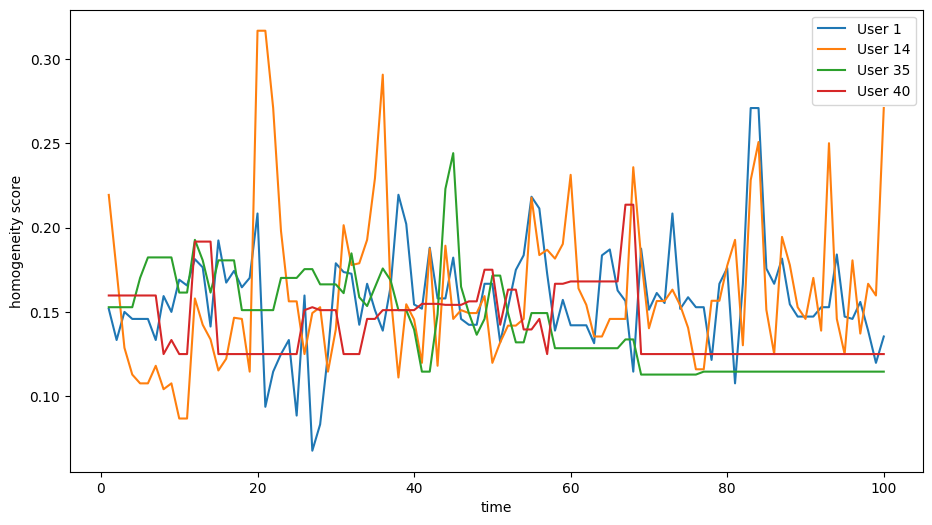

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 6)) 
plt.xlabel('time')
plt.ylabel('homogeneity score')
plt.plot(range(1,101),hom_list[0], label = f'User {user_list[0]}')
plt.plot(range(1,101),hom_list[1], label = f'User {user_list[1]}')
plt.plot(range(1,101),hom_list[2], label = f'User {user_list[2]}')
plt.plot(range(1,101),hom_list[3], label = f'User {user_list[3]}')

plt.legend(loc='upper right')